## Лабораторная работа №6
#### По дисциплине "численные методы"
Выполнил: Гаврилов М.С.  
Группа: М8О-406Б-19  
Вариант: 7

In [2]:
import numpy as np
import pylab
from tqdm import tqdm

In [3]:
def visualise(matr,t_skip,shape = [1,1]):
    pylab.figure(figsize = (shape[0],shape[1]))
    pylab.xlabel("x")
    pylab.ylabel("t")
    for i in range(matr.shape[0]):
        if(i % t_skip != 0):
            continue
            
        for j in range(matr.shape[1]):
            
            if(matr[i][j] > 0):
                pylab.plot(j,i,'s',color = (matr[i][j],0,0))
            if(matr[i][j] <= 0):
                pylab.plot(j,i,'s',color = (0,0,-matr[i][j]))
    pylab.show()

In [159]:
def numerc_derivative_1(f,x,h):
    return (f(x + h) - f(x - h))/(2*h) 

def numerc_derivative_2(f,x,h):
    return (f(x - h) - 2*f(x) + f(x + h))/(h**2) 

In [223]:
class mesh():
    def __init__(self,spatial_resolution,time_resolution,x_span,t_span,approx_method = 0):
        self.type = None
        self.approx = approx_method
        #approx_method - метод аппроксимации, используемый при наличии производных на границе
        #0 - двуточечный  1-го порядка
        #1 - двуточечный  2-го порядка
        #41 - терхточечный 2-го порядка
        #для рассчета первого слоя используетля 
        #0 - двухточечный первого порядка
        #other - двухточечный второго порядка
        
        self.spatial_resolution = spatial_resolution
        self.time_resolution = time_resolution
        self.x_span = x_span
        self.t_span = t_span
        
        #заполнение координат узлов сетки
        self.mesh_nodes = np.zeros([time_resolution,spatial_resolution,2])
        h = (x_span[1] - x_span[0])/(spatial_resolution-1)
        t = (t_span[1] - t_span[0])/(time_resolution-1)
        self.t = t
        self.h = h
        
        #заполнение значений узлов сетки
        for i in np.arange(time_resolution):
            for j in np.arange(spatial_resolution):
                self.mesh_nodes[i,j,0] = i*t
                self.mesh_nodes[i,j,1] = j*h
                
        self.mesh_nodes_value = np.zeros([time_resolution,spatial_resolution])
        
        self.object_init = True
        self.border_init = False
        self.f0_init = False
        self.f1_init = False
        
    def set_f0(self,f0): #f0 - функия, принимающая в качестве аргумента пространственную координату
        for j in range(self.spatial_resolution):
            self.mesh_nodes_value[0,j] = f0(self.mesh_nodes[0,j,1])
    
    def calculate_f1(self,f0_drv,a = 0): #f1 - вычисляется на основе производных в точке времени 0
        for i in range(self.spatial_resolution):
            if(self.approx == 0):#двухточечная первого порядка
                self.mesh_nodes_value[1,i] = self.mesh_nodes_value[0,i] + f0_drv(self.mesh_nodes[0,i,1])*self.t
            if(self.approx != 0):#двухточечная второго порядка
                if(a == 0):
                    raise ValueError("parameter 'a' required for 2-nd order approximation at layer 2")
                drv2 = numerc_derivative_1(f0_drv,i,self.h*0.001)
                self.mesh_nodes_value[1,i] = self.mesh_nodes_value[0,i] + f0_drv(self.mesh_nodes[0,i,1])*self.t
                self.mesh_nodes_value[1,i] += a*drv2*(self.t**2)/2
        
    def set_border_val(self,f0,fl):
        for i in range(self.time_resolution):
            self.mesh_nodes_value[i,0] = f0(self.mesh_nodes[i,0,0])
            self.mesh_nodes_value[i,self.spatial_resolution - 1] = fl(self.mesh_nodes[i,self.spatial_resolution - 1,0])
        self.type = 1
        
    def set_border_drv(self,f0,fl):
        self.fx0 = f0
        self.fxl = fl
        self.type = 2
        
    def set_mesh_values(self,vals):
        
        for i in range(self.time_resolution):
            for j in range(0, self.spatial_resolution):
                self.mesh_nodes_value[i,j] = vals(self.mesh_nodes[i,j])
                
                
    def solve_cross_scheme(self,a,d = 0,b = 0,c = 0,f = None,verbal = True,approx_mode = 'centre'):
        
        h = self.h
        t = self.t
        sigma = (a * t**2)/(h**2)
        
        if(verbal):
            if(sigma > 1):
                print("alert: sigma = {}. invalid solution".format(sigma))
        else:
            if(sigma > 1):
                return
                
        l = self.spatial_resolution
        
        for i in range(1, self.time_resolution - 1):
            for j in range(1, l - 1):
                self.mesh_nodes_value[i+1,j] =  a*(t**2)/(h**2)*(self.mesh_nodes_value[i,j+1] + self.mesh_nodes_value[i,j-1] - 2*self.mesh_nodes_value[i,j])
                self.mesh_nodes_value[i+1,j] += b*(t**2)/(2*h)*(self.mesh_nodes_value[i,j+1] - self.mesh_nodes_value[i,j-1])
                self.mesh_nodes_value[i+1,j] += c*(t**2)*(self.mesh_nodes_value[i,j])
                if(f != None):
                    self.mesh_nodes_value[i + 1,j] += (t**2)*f(self.mesh_nodes[i+1,j])
                    
                if(approx_mode == 'centre'):
                    #центральная аппроксимация первой производной по времени
                    self.mesh_nodes_value[i+1,j] += -(1/2)*(-4*self.mesh_nodes_value[i,j] + 2*self.mesh_nodes_value[i-1,j] - d*t*self.mesh_nodes_value[i-1,j])
                    self.mesh_nodes_value[i+1,j] *= 2/(2 + d*t)            
                else:
                    #хвостовая аппроксимация первой производной по времени
                    self.mesh_nodes_value[i+1,j] += 2*self.mesh_nodes_value[i,j] - self.mesh_nodes_value[i-1,j]
                    self.mesh_nodes_value[i+1,j] += -d*t*(self.mesh_nodes_value[i,j] - self.mesh_nodes_value[i-1,j])
                  
        
            if(self.type == 2):
                if(self.approx == 0):
                    self.mesh_nodes_value[i + 1,0]   = self.mesh_nodes_value[i + 1,1] -self.h*self.fx0(self.mesh_nodes[i + 1,0,0])
                    self.mesh_nodes_value[i + 1,l-1] = self.mesh_nodes_value[i + 1,l-2] + self.h*self.fxl(self.mesh_nodes[i + 1,l-1,0])
                if(self.approx == 1):
                    self.mesh_nodes_value[i + 1,0]   = (4*self.mesh_nodes_value[i + 1,1] - self.mesh_nodes_value[i + 1,2] -2*self.h*self.fx0(self.mesh_nodes[i + 1,0,0]))/3
                    self.mesh_nodes_value[i + 1,l-1] = (4*self.mesh_nodes_value[i + 1,l-2] - self.mesh_nodes_value[i + 1,l-3] + 2*self.h*self.fxl(self.mesh_nodes[i + 1,l-1,0]))/3
                if(self.approx == 2):               
                    self.mesh_nodes_value[i + 1,0] = (self.mesh_nodes_value[i + 1,1] + ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,0] - h*(1 +(h*b)/(2*a**2))*self.fx0(self.mesh_nodes[i + 1,0,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,0])))/(1 + (h**2)/(2*t*a**2))
                    self.mesh_nodes_value[i + 1,l-1] = (self.mesh_nodes_value[i + 1,l-2] + ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,l-1] + h*(1 -(h*b)/(2*a**2))*self.fxl(self.mesh_nodes[i + 1,l-1,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,l-1])))/(1 + (h**2)/(2*t*a**2))
    
    
    def solve_implicit_scheme(self,a,d = 0,b = 0,c = 0,f = None,verbal = True):
        t = self.t
        h = self.h
        
        l = self.spatial_resolution
        alpha = -((a / (h**2)) - (b / (2*h)))
        betha = (1/(t**2) + d/t + ((2*a) / (h**2)) - c)
        gamma = -((a / (h**2)) + (b / (2*h)))
        
        for i in range(1,self.time_resolution - 1):
            matr = np.zeros([self.spatial_resolution,self.spatial_resolution])
            res = np.zeros([self.spatial_resolution])
            
            #граничные значения в матрице
            if(self.type == 1):
                matr[0,0] = 1
                matr[l-1,l-1] = 1

                res[0]  = self.mesh_nodes_value[i + 1,0  ]
                res[l-1]= self.mesh_nodes_value[i + 1,l-1]

            if(self.type == 2):
                if(self.approx == 0):
                    matr[0,0] =  1
                    matr[0,1] = -1 
                    matr[l-1,l-2] = -1
                    matr[l-1,l-1] =  1

                    res[0]   =  -h*self.fx0(self.mesh_nodes[i+1,0,0])
                    res[l-1] =  h*self.fxl(self.mesh_nodes[i+1,l-1,0])
                if(self.approx == 1):
                    matr[0,0] = -3
                    matr[0,1] = +4
                    matr[0,2] = -1 
                    matr[l-1,l-3] = +1
                    matr[l-1,l-2] = -4
                    matr[l-1,l-1] = +3

                    res[0]   =  2*h*self.fx0(self.mesh_nodes[i+1,0,0])
                    res[l-1] =  2*h*self.fxl(self.mesh_nodes[i+1,l-1,0])
                if(self.approx == 2):
                    matr[0,0] =  (1 + (h**2)/(2*t*a**2))
                    matr[0,1] = -1 
                    matr[l-1,l-2] = -1
                    matr[l-1,l-1] =  (1 + (h**2)/(2*t*a**2))
                    
                    res[0]   = ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,0] - h*(1 +(h*b)/(2*a**2))*self.fx0(self.mesh_nodes[i + 1,0,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,0]))
                    res[l-1] = ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,l-1] + h*(1 -(h*b)/(2*a**2))*self.fxl(self.mesh_nodes[i + 1,l-1,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,l-1]))
            
            #заполнение диагоналей 
            for j in range(1,l-1):
                matr[j,j-1] = alpha
                matr[j,j+0] = betha
                matr[j,j+1] = gamma

                res[j] =  (2*self.mesh_nodes_value[i,j] - self.mesh_nodes_value[i-1,j])/(t**2)
                res[j] += d*self.mesh_nodes_value[i,j]/t
                if(f != None):
                    res[j] += f(self.mesh_nodes[i+1,j])

            next_row = np.linalg.solve(matr,res)
            self.mesh_nodes_value[i + 1] = next_row
        
        
    
    def print(self,skip = 1):
        vis_mesh = self.mesh_nodes_value / np.max(np.abs(self.mesh_nodes_value))
        visualise(vis_mesh,t_skip = skip,shape = [self.x_span[1] - self.x_span[0],self.t_span[1] - self.t_span[0]])
        
    def compare(self,other):
        return np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))
        
    def compare_verbal(self,other,skip = 10):
        print("mean abs error: {}".format(np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))))
        print("error map:")
        dif_mesh = (self.mesh_nodes_value - other.mesh_nodes_value)
        dif_mesh = dif_mesh / np.max(np.abs(dif_mesh))
        visualise(dif_mesh,t_skip = skip,shape = [self.x_span[1] - self.x_span[0],self.t_span[1] - self.t_span[0]])
        
        return np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))
    
    def compare_by_layers(self,other,skip = 10):
        arr = []
        for i in range(0,len(self.mesh_nodes_value),skip):
                arr.append([i,np.mean(np.abs(self.mesh_nodes_value[i] - other.mesh_nodes_value[i])),np.mean((self.mesh_nodes_value[i] - other.mesh_nodes_value[i]))])
        arr = np.array(arr)
        
        pylab.figure(figsize = (8,5))
        pylab.xlabel("temporal layer",color = "grey")
        pylab.ylabel("mean error at layer",color = "grey")
            
        pylab.xlim([0,len(self.mesh_nodes_value)])
        
        pylab.plot(arr[:,0],arr[:,1],label = "abs error")
        pylab.plot(arr[:,0],arr[:,2],label = "no abs error")
        pylab.legend()
        pylab.show()
        

In [224]:
def Xi0(x):
    return np.exp(-x)*np.cos(x)
def d_Xi0(x):
    return -np.exp(-x)*np.cos(x)
def u_bd_left(t):
    return np.exp(-t)*np.cos(2*t)
def u_bd_right(t):
    return 0

#### Истинное решение

In [225]:
def f_true(crd):
    t,x = crd
    return np.exp(-t-x)*np.cos(x)*np.cos(2*t)

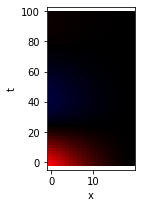

In [226]:
test_mesh = mesh(20,100,[0,0.5*np.pi],[0,3])
test_mesh.set_mesh_values(f_true)
test_mesh.print(skip = 2)

#### Решение с использованием схемы "крест"

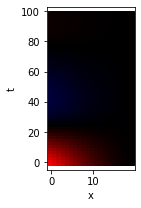

In [227]:
cross_mesh = mesh(20,100,[0,0.5*np.pi],[0,3],approx_method = 0)
cross_mesh.set_f0(Xi0)
cross_mesh.calculate_f1(d_Xi0,a = 1)
cross_mesh.set_border_val(u_bd_left,u_bd_right)

cross_mesh.solve_cross_scheme(a=1,d=2,b=2,c=-3)
cross_mesh.print(skip = 2)

mean abs error: 0.0008280366971993976
error map:


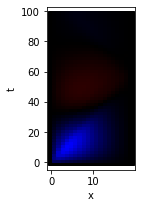

In [228]:
cross_error = test_mesh.compare_verbal(cross_mesh,skip=2)

График зависимости погрешности аппрокисимации на временном слое его номера

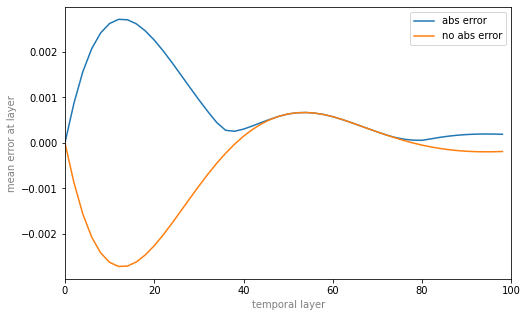

In [229]:
test_mesh.compare_by_layers(cross_mesh,skip=2)

Решение с аппроксимацией на первом слое второго порядка:

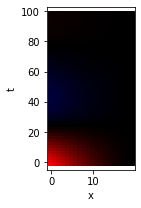

In [230]:
cross_mesh = mesh(20,100,[0,0.5*np.pi],[0,3],approx_method = 1)
cross_mesh.set_f0(Xi0)
cross_mesh.calculate_f1(d_Xi0,a = 1)
cross_mesh.set_border_val(u_bd_left,u_bd_right)

cross_mesh.solve_cross_scheme(a=1,d=2,b=2,c=-3)
cross_mesh.print(skip = 2)

mean abs error: 0.0008321981754506424
error map:


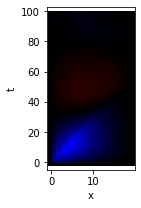

In [231]:
cross_error = test_mesh.compare_verbal(cross_mesh,skip=2)

#### Решение с использованием неявной схемы

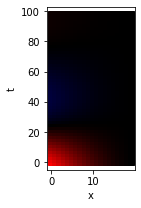

In [232]:
implicit_mesh = mesh(20,100,[0,0.5*np.pi],[0,3])
implicit_mesh.set_f0(Xi0)
implicit_mesh.calculate_f1(d_Xi0)
implicit_mesh.set_border_val(u_bd_left,u_bd_right)

implicit_mesh.solve_implicit_scheme(a=1,d=2,b=2,c=-3)
implicit_mesh.print(skip = 2)

mean abs error: 0.003707617386414305
error map:


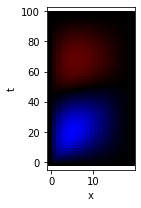

In [233]:
cross_error = test_mesh.compare_verbal(implicit_mesh,skip=2)

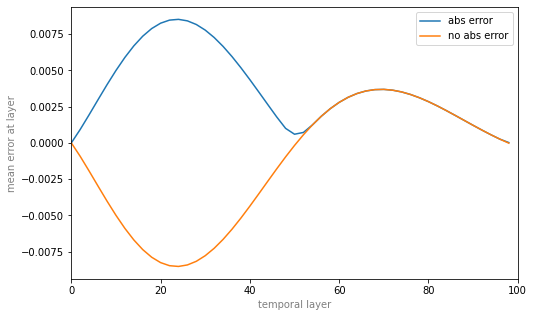

In [234]:
test_mesh.compare_by_layers(implicit_mesh,skip=2)

Решение с аппроксимацией на первом слое второго порядка:

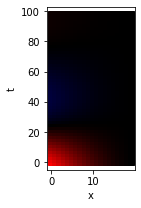

In [238]:
implicit_mesh = mesh(20,100,[0,0.5*np.pi],[0,3],approx_method = 1)
implicit_mesh.set_f0(Xi0)
implicit_mesh.calculate_f1(d_Xi0,a = 1)
implicit_mesh.set_border_val(u_bd_left,u_bd_right)

implicit_mesh.solve_implicit_scheme(a=1,d=2,b=2,c=-3)
implicit_mesh.print(skip = 2)

mean abs error: 0.003711111563741559
error map:


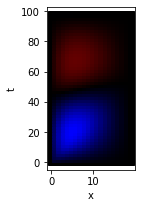

In [239]:
cross_error = test_mesh.compare_verbal(implicit_mesh,skip=2)

### Исследование зависимости погрешности от мелкости сетки

##### На квадратной сетке

По квадратной сетке (только неявный метод)

In [178]:
arr = []
for i in tqdm(range(10,500,20)):
    
    exsl_mesh = mesh(i,i,[0,0.5*np.pi],[0,3])
    exsl_mesh.set_f0(Xi0)
    exsl_mesh.calculate_f1(d_Xi0)
    exsl_mesh.set_border_val(u_bd_left,u_bd_right)

    ril_mesh = mesh(i,i,[0,0.5*np.pi],[0,3])
    ril_mesh.set_mesh_values(f_true)

    exsl_mesh.solve_implicit_scheme(a=1,d=2,b=2,c=-3)
    err = ril_mesh.compare(exsl_mesh)
    arr.append([i,err])
    
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:14<00:00,  7.78s/it]


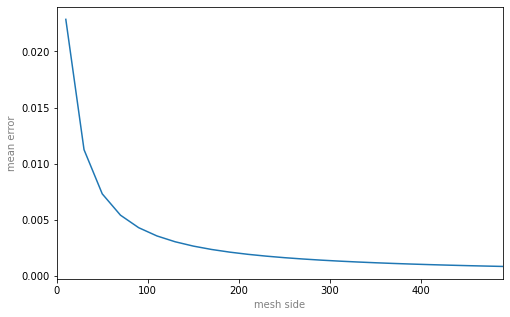

In [179]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

По прямоугольной сетке (сравнение двух методов)

In [183]:
arr = []
for i in tqdm(range(10,300,20)):
    
    exsl_mesh = mesh(i,3*i,[0,0.5*np.pi],[0,3])
    exsl_mesh.set_f0(Xi0)
    exsl_mesh.calculate_f1(d_Xi0)
    exsl_mesh.set_border_val(u_bd_left,u_bd_right)

    ril_mesh = mesh(i,3*i,[0,0.5*np.pi],[0,3])
    ril_mesh.set_mesh_values(f_true)

    exsl_mesh.solve_implicit_scheme(a=1,d=2,b=2,c=-3)
    err_im = ril_mesh.compare(exsl_mesh)
    exsl_mesh.solve_cross_scheme(a=1,d=2,b=2,c=-3)
    err_cr = ril_mesh.compare(exsl_mesh)
    arr.append([i,err_im,err_cr])
    
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:43<00:00, 10.92s/it]


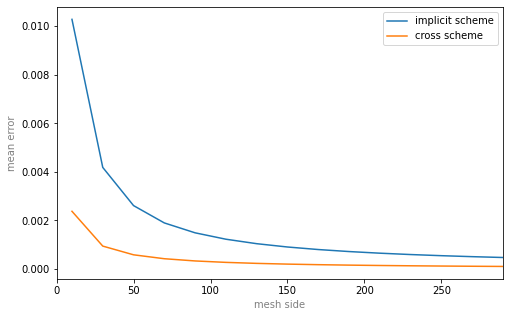

In [184]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1],label = "implicit scheme")
pylab.plot(arr[:,0],arr[:,2],label = "cross scheme")
pylab.legend()
pylab.show()

Варьируем один из параметров сетки, фиксируя другой

In [185]:
arr = []
for i in tqdm(range(10,300,20)):
    
    exsl_mesh = mesh(50,i,[0,0.5*np.pi],[0,3])
    exsl_mesh.set_f0(Xi0)
    exsl_mesh.calculate_f1(d_Xi0)
    exsl_mesh.set_border_val(u_bd_left,u_bd_right)

    ril_mesh = mesh(50,i,[0,0.5*np.pi],[0,3])
    ril_mesh.set_mesh_values(f_true)

    exsl_mesh.solve_implicit_scheme(a=1,d=2,b=2,c=-3)
    err_h_fixed = ril_mesh.compare(exsl_mesh)
    
    
    
    exsl_mesh = mesh(i,50,[0,0.5*np.pi],[0,3])
    exsl_mesh.set_f0(Xi0)
    exsl_mesh.calculate_f1(d_Xi0)
    exsl_mesh.set_border_val(u_bd_left,u_bd_right)

    ril_mesh = mesh(i,50,[0,0.5*np.pi],[0,3])
    ril_mesh.set_mesh_values(f_true)
    
    exsl_mesh.solve_implicit_scheme(a=1,d=2,b=2,c=-3)
    err_t_fixed = ril_mesh.compare(exsl_mesh)
    arr.append([i,err_h_fixed,err_t_fixed])
    
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.28s/it]


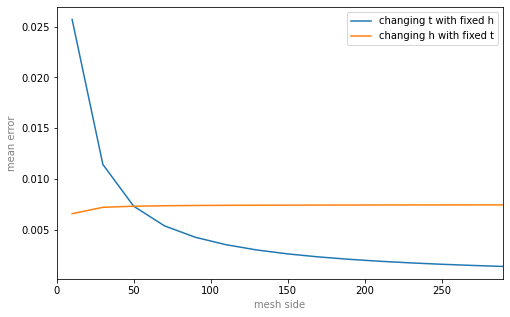

In [186]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1],label = "changing t with fixed h")
pylab.plot(arr[:,0],arr[:,2],label = "changing h with fixed t")
pylab.legend()
pylab.show()

По графику выше видно, что измельчение сетки по x не имеет смысла, если количество временных слоев меньше, чем количество пространственных. При фиксированном h уменьшение t даест прирост точности, но не наоборот

### Вывод
В ходе выполнения этой лабораторной работы я ознакомился с методами численного решения уравнений гиперболичесткого типа. Я реализовал схему "крест" и неявную схему, а также различные методы аппроксимации производных на границе (которые в моей задаче не пригодились, ибо она имела краевые условия первого рода). Также я реализовал два варианта аппроксимации значений функции на первом временном слое. Исследование зависимости погрешности от параметров сетки показало, что при прочих равных схема "крест" дает большую точность, чем неявная схема, что объясняется тем, что последняя имееет погрешность O(h + t^2) а погрешность схемы "крест" равна O(h^2 + t^2).